# Helper Functions

In [20]:
### Helper functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import calendar

def plot_weekly_returns_heatmap(df, title="Weekly Percentage Returns (Heatmap)", vmin=-5, vmax=5):
    """
    Generates a heatmap of weekly percentage returns from a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing 'date' and 'price' columns.
    - title (str): Title of the heatmap plot.
    - vmin (float): Minimum value for color normalization.
    - vmax (float): Maximum value for color normalization.
    """
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop rows with invalid or missing dates
    df = df.dropna(subset=['date'])

    # Set the 'date' column as the index
    df.set_index('date', inplace=True)

    # Resample price to weekly and calculate weekly percentage change
    weekly_returns = df['price'].resample('W').ffill().pct_change() * 100  # Weekly returns in percentage

    # Drop NaN from the first week and prepare data for pivot table
    weekly_returns = weekly_returns.dropna().to_frame(name='weekly_return')
    weekly_returns['year'] = weekly_returns.index.year
    weekly_returns['week'] = weekly_returns.index.isocalendar().week

    # Create a pivot table
    weekly_pivot = weekly_returns.pivot_table(values='weekly_return', index='year', columns='week', aggfunc='mean')

    # Normalize the color map
    divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    # Plotting
    fig, ax = plt.subplots(figsize=(24, 10))  # Larger figure size for better readability

    # Heatmap
    sns.heatmap(
        weekly_pivot, 
        cmap='RdYlGn',  # Diverging colormap: red for loss, gray at 0, green for profit
        norm=divnorm,   # Normalize colors
        annot=True,     # Overlay percentage values
        fmt=".1f",      # Format to one decimal place
        cbar_kws={'label': 'Weekly Return (%)'},
        ax=ax
    )

    # Add upper row to indicate months
    total_weeks = weekly_pivot.columns.max()  # Number of weeks in the data
    weeks_per_month = [4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 4]  # Approximate weeks per month (Jan-Dec)
    weeks_per_month = weeks_per_month[:total_weeks // 4]  # Adjust for actual weeks

    month_positions = [sum(weeks_per_month[:i]) for i in range(len(weeks_per_month) + 1)]
    month_labels = list(calendar.month_abbr[1:13])[:len(weeks_per_month)]

    # Place month labels and draw vertical lines
    for i, pos in enumerate(month_positions[:-1]):
        ax.axvline(pos, color="black", linestyle="--", linewidth=0.8)  # Vertical line for month separation
        if i < len(month_labels):
            ax.text(pos + weeks_per_month[i] / 2, weekly_pivot.shape[0] + 0.5, month_labels[i],
                    fontsize=12, ha="center", va="center", color="black", transform=ax.transData)

    # Update titles and labels
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Weeks", fontsize=14)
    ax.set_ylabel("Years", fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_volatility(df, price_col='price', date_col='date', window=30, title="Rolling Volatility"):
    """
    Plots the rolling volatility of the price over time.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with date and price columns.
    - price_col (str): Column name for prices.
    - date_col (str): Column name for dates.
    - window (int): Rolling window size for volatility calculation.
    - title (str): Title for the plot.
    """
    # Ensure 'date' column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Sort by date
    df = df.sort_values(by=date_col)

    # Calculate daily returns
    df['daily_return'] = df[price_col].pct_change()

    # Calculate rolling volatility
    df['rolling_volatility'] = df['daily_return'].rolling(window=window).std()

    # Plot rolling volatility
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_col], df['rolling_volatility'], label=f'{window}-Day Rolling Volatility', color='blue')
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Volatility (Standard Deviation)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

def plot_volume(df, volume_col='volume', date_col='date', title="Trading Volume Over Time"):
    """
    Plots the trading volume over time with a logarithmic scale.
    
    Handles zeros and negative values in the volume column.
    """
    # Ensure 'date' column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Replace zeros or negative values in the volume column
    df[volume_col] = df[volume_col].replace(0, 1)  # Replace zeros with 1
    df = df[df[volume_col] > 0]  # Drop rows with negative values

    # Sort by date
    df = df.sort_values(by=date_col)

    # Plot trading volume with a logarithmic scale
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_col], df[volume_col], label='Trading Volume', color='green')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Volume (Log Scale)", fontsize=12)
    plt.legend()
    plt.grid()

    # Ensure y-axis shows full numbers, not in scientific notation
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)

    plt.show()

# Bitcoin

Loading Dataset

In [2]:
import pandas as pd

btc = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/btc_processed.csv")
btc.head()

,date,price,volume,change_rate
0,2024-12-10,96663.7,2.702524e+10,-0.71
1,2024-12-09,97359.4,3.125334e+10,-3.72
2,2024-12-08,101115.8,1.303686e+10,1.28
3,2024-12-07,99837.0,1.182469e+10,0.08
4,2024-12-06,99760.7,2.129791e+10,2.88


### Descriptive analysis

In [2]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4397 entries, 0 to 4396
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4397 non-null   object 
 1   price        4397 non-null   float64
 2   volume       4397 non-null   float64
 3   change_rate  4397 non-null   float64
dtypes: float64(3), object(1)
memory usage: 137.5+ KB


In [3]:
btc.describe()

,price,volume,change_rate
count,4397.000000,4.397000e+03,4397.000000
mean,16315.369616,5.576563e+11,0.355777
std,20821.667528,6.606697e+12,6.957987
min,12.200000,1.575840e+05,-57.210000
25%,564.600000,1.962880e+07,-1.260000
50%,7230.800000,1.425717e+09,0.140000
75%,26882.900000,4.403912e+09,1.820000
max,101115.800000,1.838006e+14,336.840000


### Time series trends

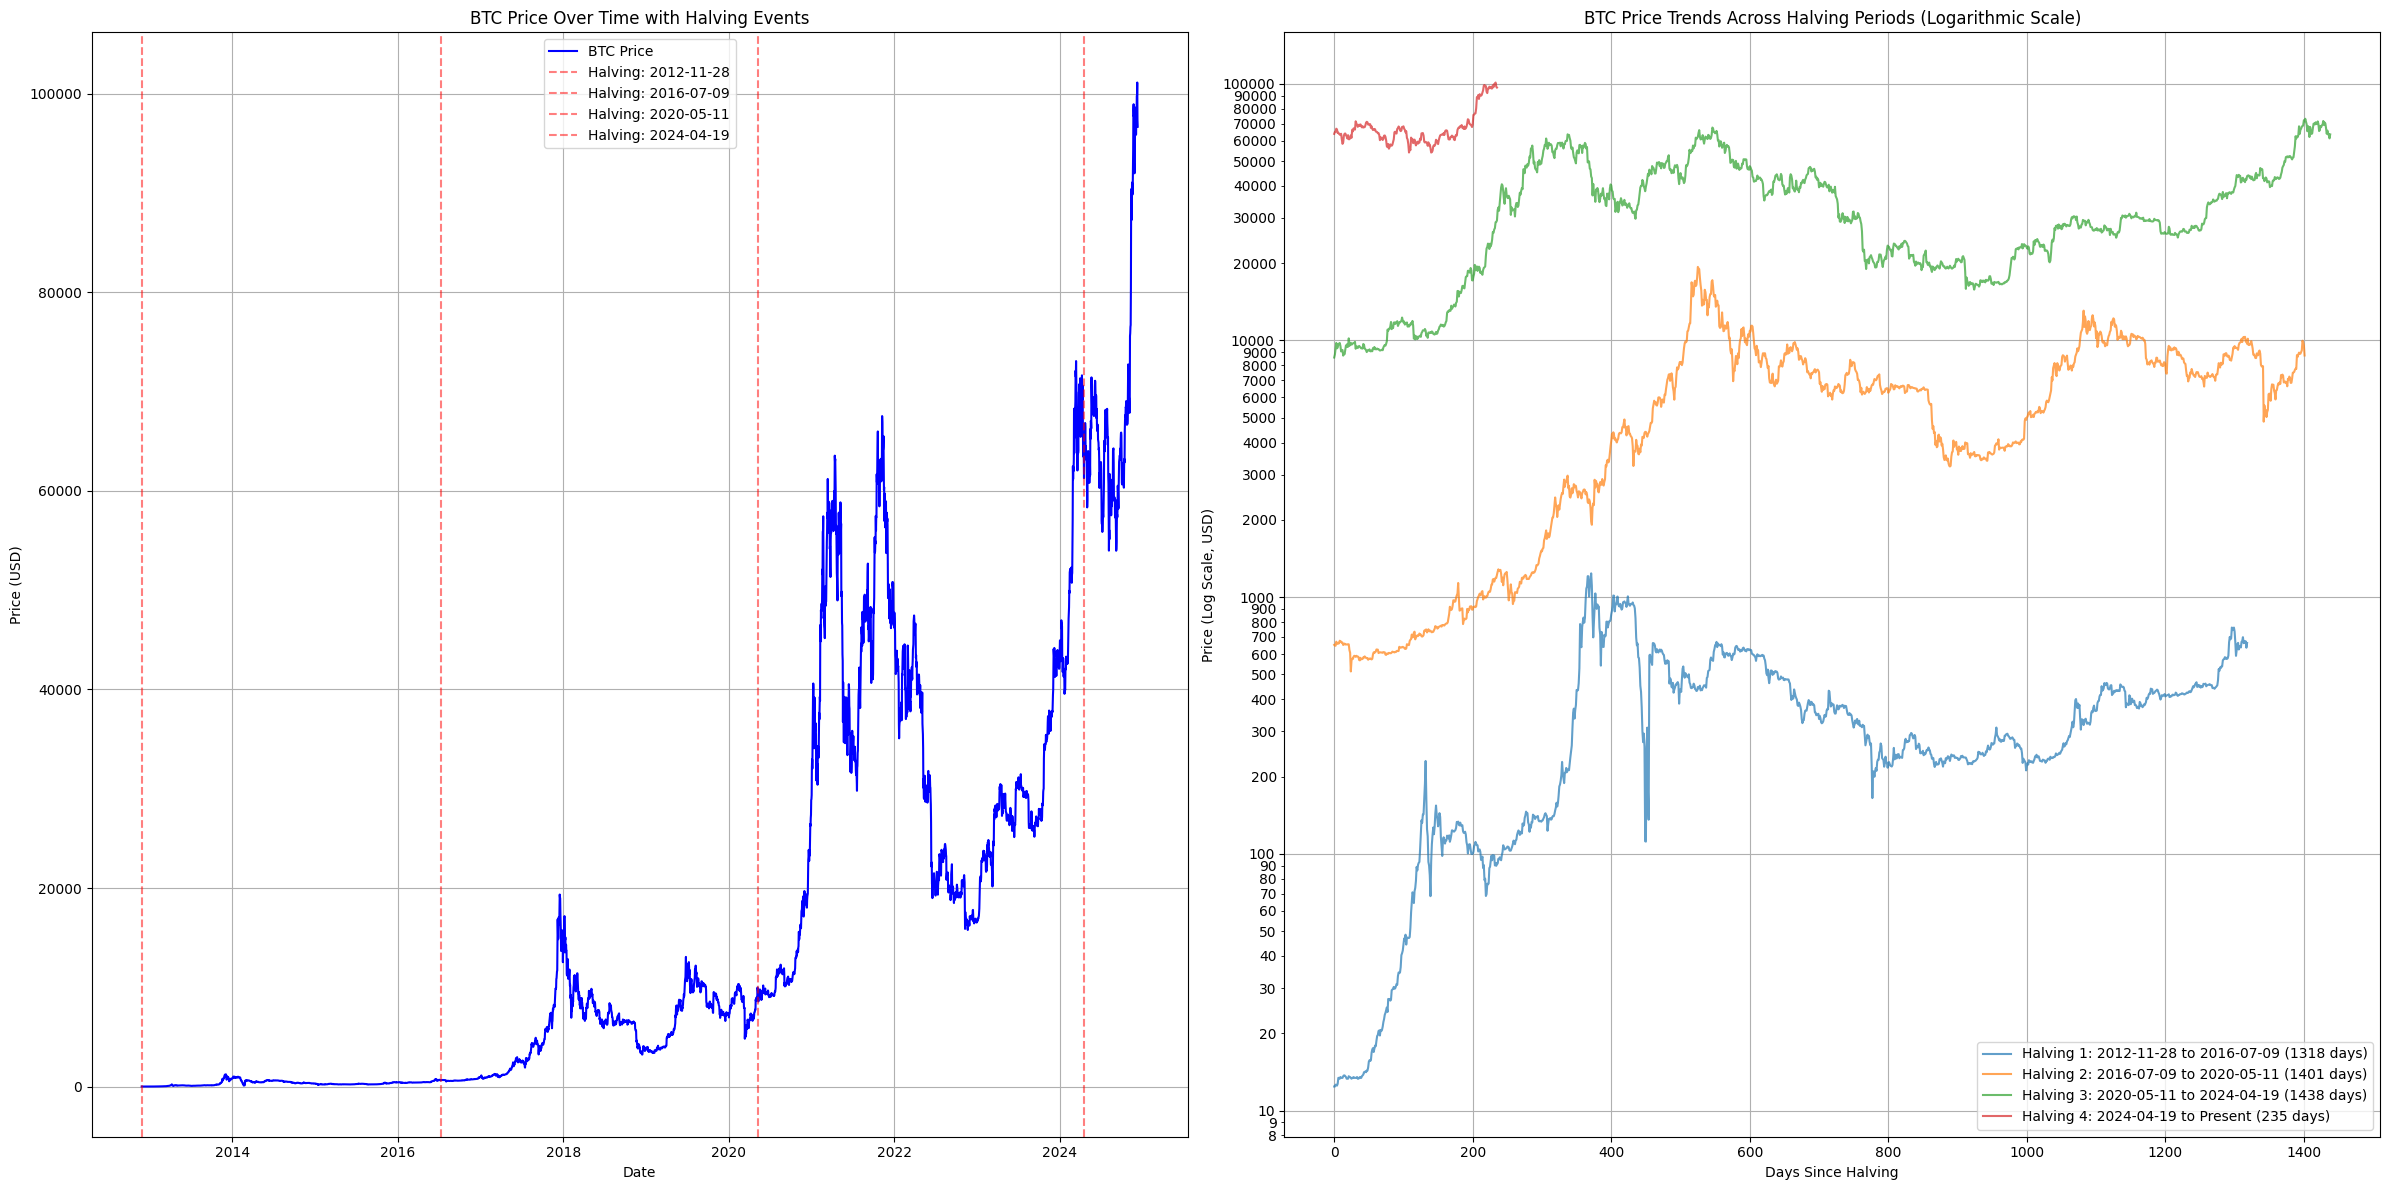

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Assuming the BTC data is already loaded
btc['date'] = pd.to_datetime(btc['date'])

# List of halving dates
halving_dates = pd.to_datetime(["2012-11-28", "2016-07-09", "2020-05-11", "2024-04-19"])

# Create a function to extract and normalize data between halving dates
def get_halving_windows(data, halving_dates):
    halving_windows = []
    for i in range(len(halving_dates) - 1):
        start_date = halving_dates[i]
        end_date = halving_dates[i + 1]
        # Filter data for the window between two halving events
        halving_window = data[(data['date'] >= start_date) & (data['date'] < end_date)].copy()
        halving_window['days_since_halving'] = (halving_window['date'] - start_date).dt.days
        halving_windows.append((start_date, end_date, halving_window))
    
    # Handle the final incomplete halving period
    final_start_date = halving_dates[-1]
    halving_window = data[data['date'] >= final_start_date].copy()
    halving_window['days_since_halving'] = (halving_window['date'] - final_start_date).dt.days
    halving_windows.append((final_start_date, None, halving_window))
    
    return halving_windows

# Apply the function to extract data
halving_windows = get_halving_windows(btc, halving_dates)

# Create the two plots
plt.figure(figsize=(24, 12))

# First Plot: BTC Price Over Time
plt.subplot(1, 2, 1)
plt.plot(btc['date'], btc['price'], label='BTC Price', color='blue')
for halving_date in halving_dates:
    plt.axvline(halving_date, color='red', linestyle='--', alpha=0.5, label=f'Halving: {halving_date.date()}')
plt.title('BTC Price Over Time with Halving Events')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()

# Second Plot: BTC Price Trends Across Halving Periods (Log Scale)
plt.subplot(1, 2, 2)
for i, (start_date, end_date, halving_window) in enumerate(halving_windows):
    num_days = halving_window['days_since_halving'].max() if not halving_window.empty else 0
    end_date_str = f"{end_date.date()}" if end_date else "Present"
    plt.plot(
        halving_window['days_since_halving'], 
        halving_window['price'], 
        alpha=0.7,  # Add transparency to distinguish overlapping lines
        label=f"Halving {i + 1}: {start_date.date()} to {end_date_str} ({num_days} days)"
    )

# Apply logarithmic scale to the y-axis
plt.yscale('log')

# Use a ScalarFormatter for y-axis to avoid scientific notation
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

# Update plot details for log scale
plt.title('BTC Price Trends Across Halving Periods (Logarithmic Scale)')
plt.xlabel('Days Since Halving')
plt.ylabel('Price (Log Scale, USD)')
plt.legend()
plt.grid()

# Show Plots
plt.tight_layout()
plt.show()

### Return rates

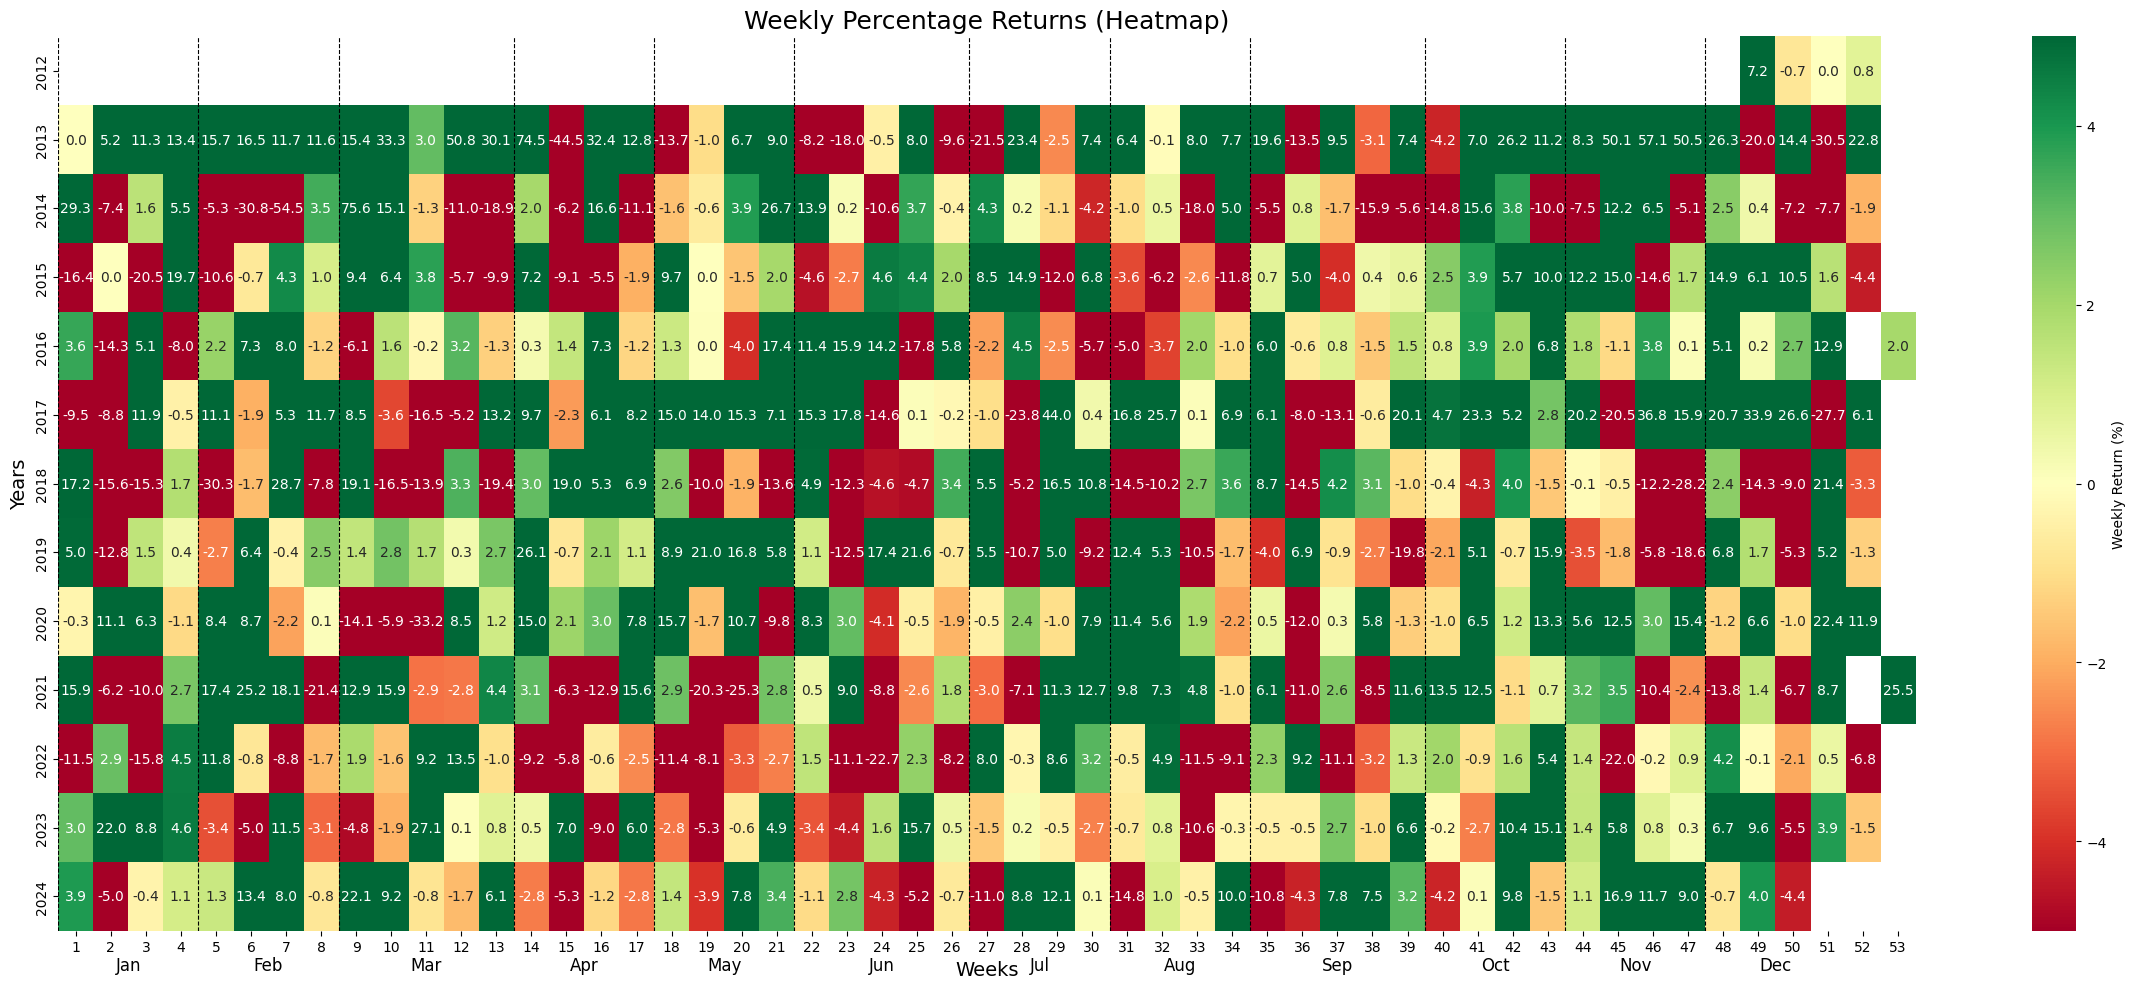

In [10]:
plot_weekly_returns_heatmap(btc)

/var/folders/vx/qnjn5crx6n17qty1n6m8kf4w0000gn/T/ipykernel_17172/2403153525.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.resample('W', on='date')['price'].last().pct_change() * 100)  # Weekly returns


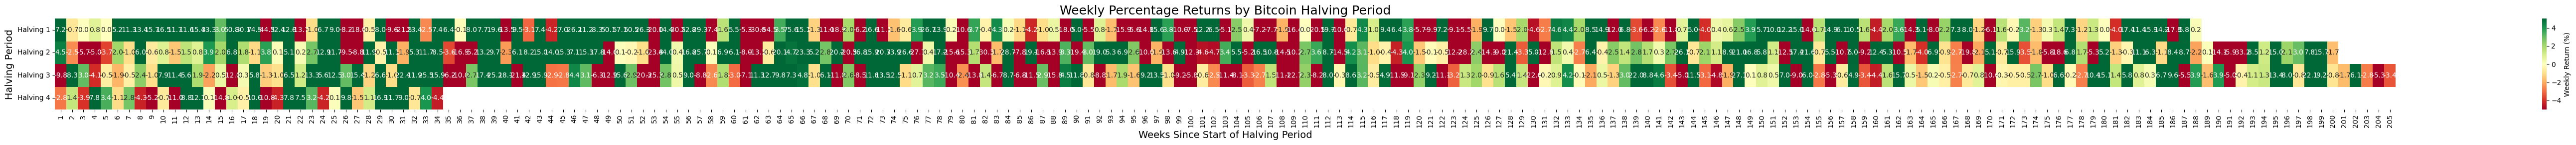

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# Define Bitcoin halving dates
halving_dates = [
    pd.Timestamp("2012-11-28"),
    pd.Timestamp("2016-07-09"),
    pd.Timestamp("2020-05-11"),
    pd.Timestamp("2024-04-19")  # Next halving
]

# Function to assign halving periods based on the date
def assign_halving_period(date):
    for i in range(len(halving_dates) - 1):
        if halving_dates[i] <= date < halving_dates[i + 1]:
            return f"Halving {i + 1}"
    if date >= halving_dates[-1]:
        return f"Halving {len(halving_dates)}"
    return None

# Ensure the 'date' column is in datetime format
btc['date'] = pd.to_datetime(btc['date'], errors='coerce')

# Drop rows with invalid or missing dates
btc = btc.dropna(subset=['date'])

# Assign halving periods to each date
btc['halving_period'] = btc['date'].apply(assign_halving_period)

# Filter out rows without a valid halving period
btc = btc.dropna(subset=['halving_period'])

# Resample price to weekly frequency and calculate weekly percentage returns
weekly_returns = (
    btc
    .groupby('halving_period')  # Group by halving periods
    .apply(lambda x: x.resample('W', on='date')['price'].last().pct_change() * 100)  # Weekly returns
    .reset_index(name='weekly_return')  # Reset index and name the column
)

# Calculate weeks since the start of each halving period
weekly_returns['weeks_since_start'] = (
    weekly_returns
    .groupby('halving_period')['date']
    .rank(method='dense')
    .astype(int) - 1  # Start week numbering from 0
)

# Create a pivot table for the heatmap
weekly_pivot = weekly_returns.pivot_table(
    values='weekly_return',
    index='halving_period',
    columns='weeks_since_start',
    aggfunc='mean'
)

# Define a normalized colormap with fixed range: -5% to +5%
divnorm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(60, 3))  # Larger figure size for better readability

sns.heatmap(
    weekly_pivot,
    cmap='RdYlGn',  # Diverging colormap: red for loss, gray (centered at 0), green for profit
    norm=divnorm,   # Centered normalization with fixed range
    annot=True,     # Overlay percentage values
    fmt=".1f",      # Format to one decimal place
    cbar_kws={'label': 'Weekly Return (%)'},  # Add color bar label
    ax=ax
)

# Update main plot titles and axis labels
ax.set_title("Weekly Percentage Returns by Bitcoin Halving Period", fontsize=18)
ax.set_xlabel("Weeks Since Start of Halving Period", fontsize=14)
ax.set_ylabel("Halving Period", fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Volatility and Volume analysis

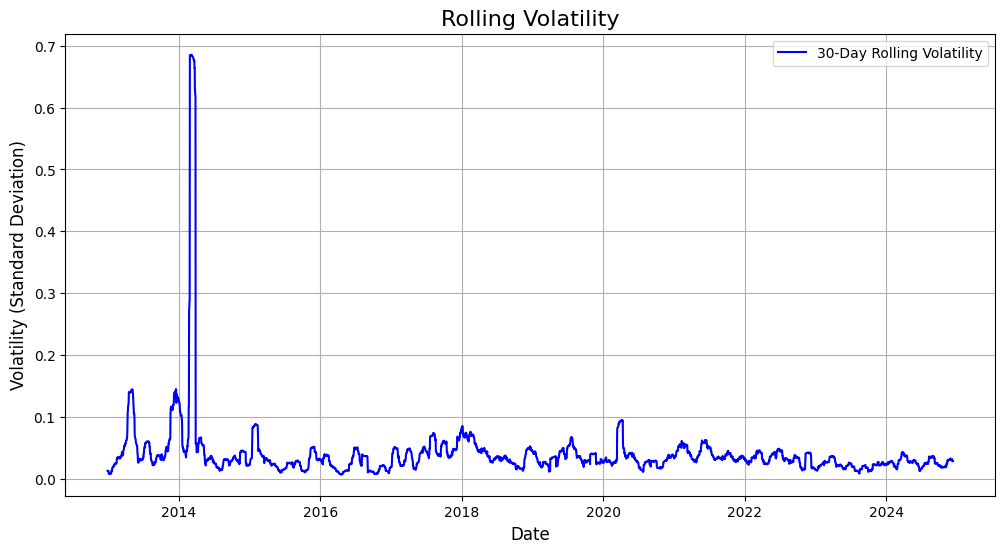

In [13]:
plot_volatility(btc)

AttributeError: This method only works with the ScalarFormatter

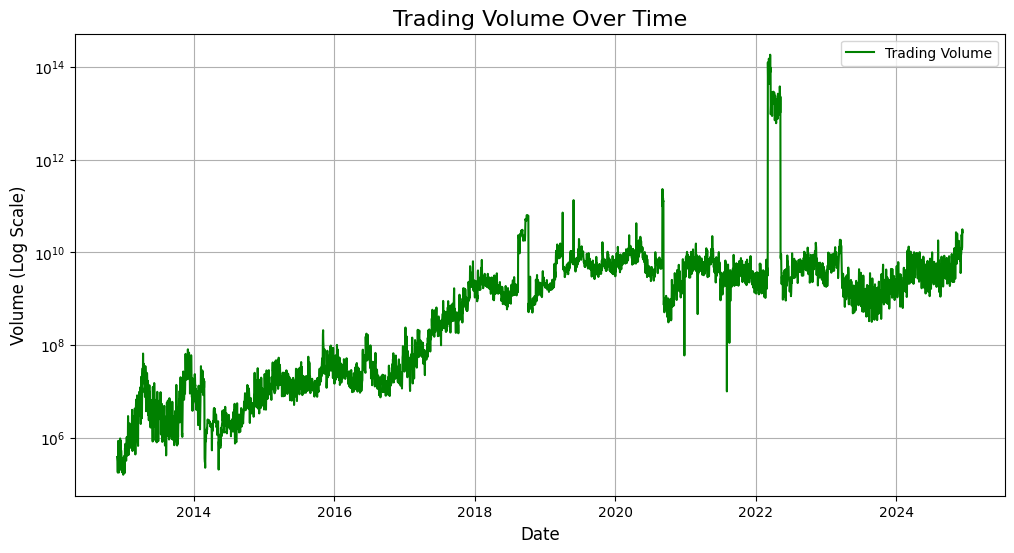

In [19]:
plot_volume(btc)

# S&P 500 ETF

Loading Dataframe

In [21]:
import pandas as pd

sp500 = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/sp500_processed.csv")

sp500.head()

,date,price,volume,change_rate
0,2012-11-27,140.33,127850321.0,0.000000
1,2012-11-28,141.46,176637479.0,0.805245
2,2012-11-29,142.12,150798733.0,0.466563
3,2012-11-30,142.15,136298627.0,0.021109
4,2012-12-03,141.45,124385047.0,-0.492438


### Descriptive Analysis

In [22]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030 entries, 0 to 3029
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3030 non-null   object 
 1   price        3030 non-null   float64
 2   volume       3030 non-null   float64
 3   change_rate  3030 non-null   float64
dtypes: float64(3), object(1)
memory usage: 94.8+ KB


In [23]:
sp500.describe()

,price,volume,change_rate
count,3030.000000,3.030000e+03,3030.000000
mean,306.322366,9.263975e+07,0.053714
std,113.712850,4.625819e+07,1.055234
min,140.030000,2.027001e+07,-10.942373
25%,208.350000,6.203322e+07,-0.365154
50%,278.425000,8.146850e+07,0.065190
75%,404.317500,1.098015e+08,0.563383
max,607.810000,5.072443e+08,9.060327


### Time series trend

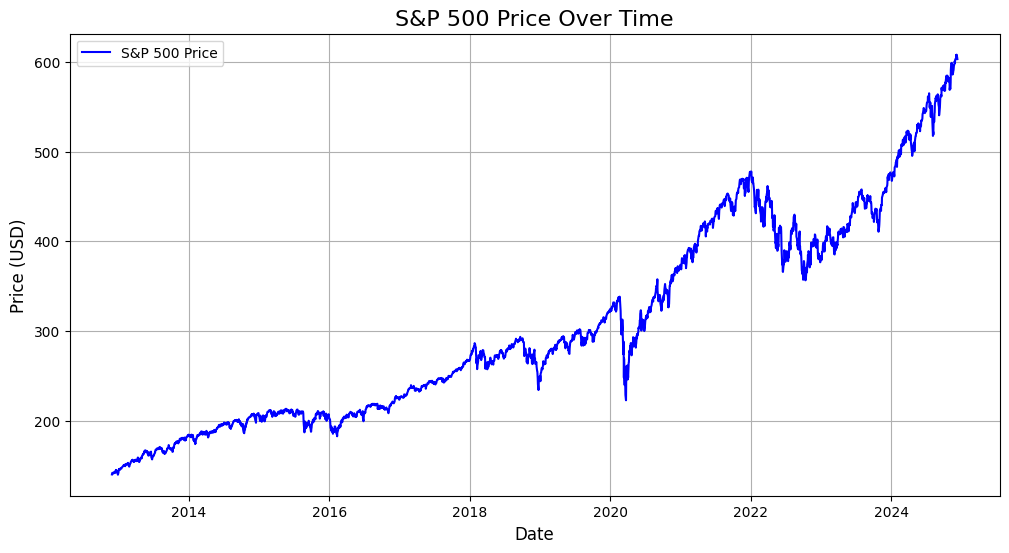

In [25]:
import matplotlib.pyplot as plt

def plot_sp500_over_time(df, date_col='date', price_col='price', title="S&P 500 Price Over Time"):
    """
    Plots the S&P 500 price over time.
    
    Parameters:
    - df (pd.DataFrame): The S&P 500 data with date and price columns.
    - date_col (str): Column name for dates.
    - price_col (str): Column name for prices.
    - title (str): Title of the plot.
    """
    # Ensure 'date' column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Sort by date
    df = df.sort_values(by=date_col)

    # Plot price over time
    plt.figure(figsize=(12, 6))
    plt.plot(df[date_col], df[price_col], label="S&P 500 Price", color="blue")
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price (USD)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_sp500_over_time(sp500, date_col='date', price_col='price', title="S&P 500 Price Over Time")

### Return rate

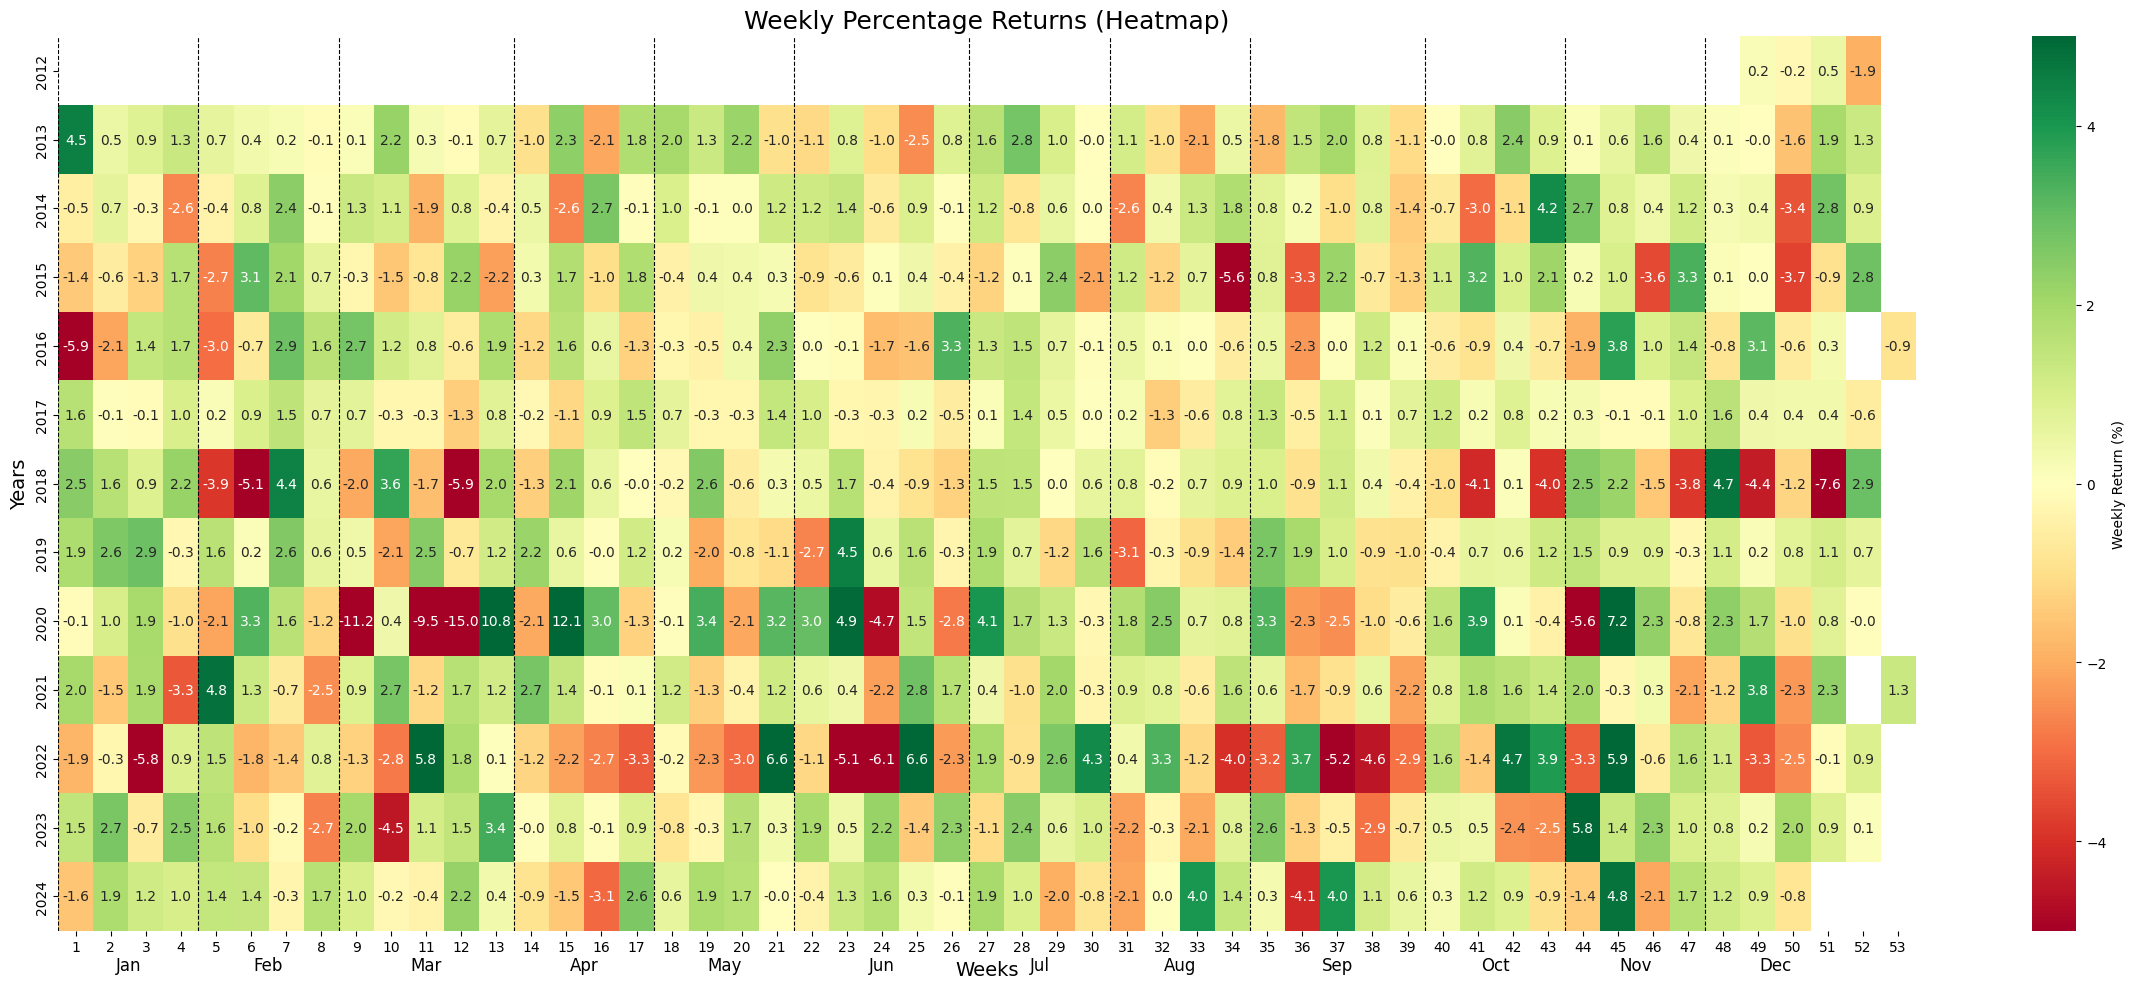

In [26]:
plot_weekly_returns_heatmap(sp500)

### Volatility and Volume analysis

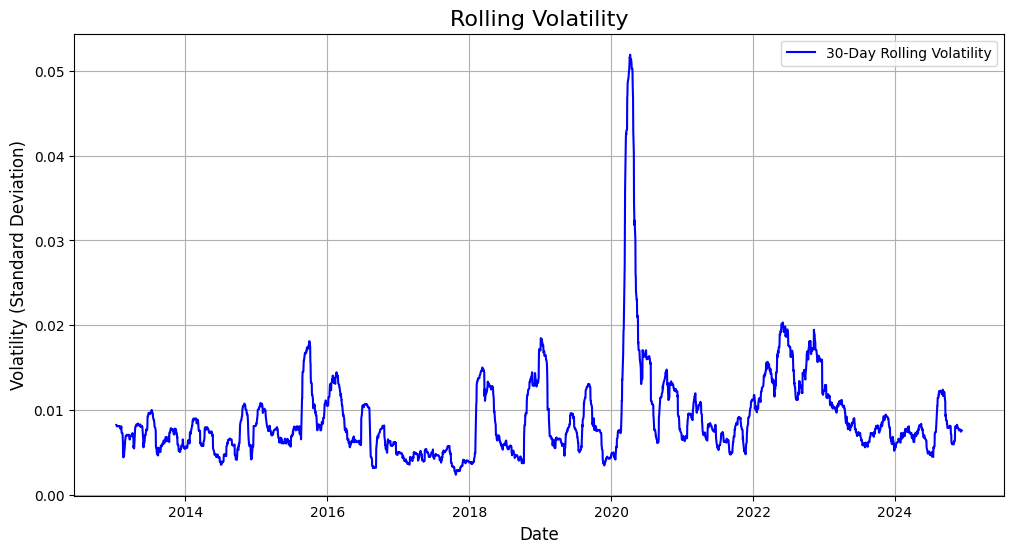

In [27]:
plot_volatility(sp500)

AttributeError: This method only works with the ScalarFormatter

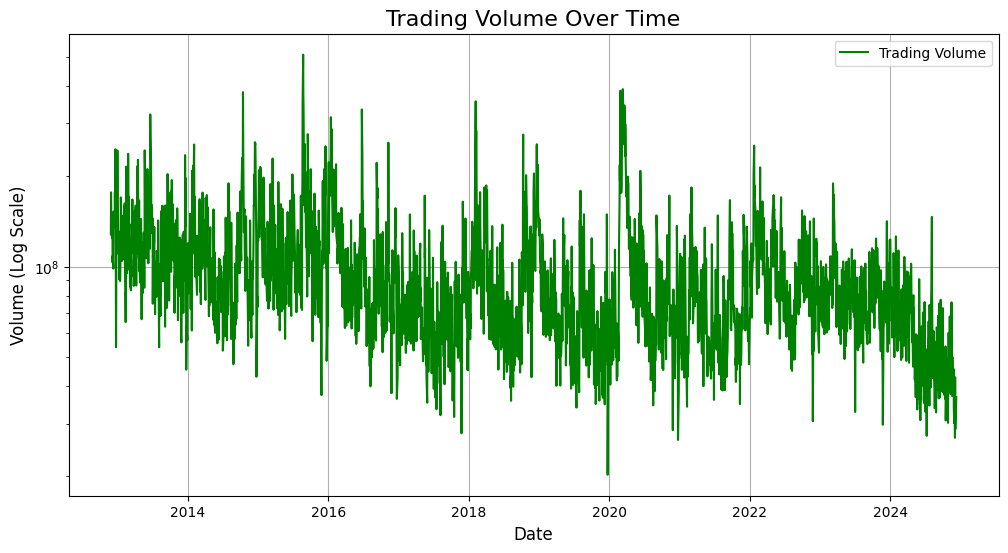

In [28]:
plot_volume(sp500)

# Investment sector in SPDR

### Dashboard

In [37]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Load the processed data
df = pd.read_csv("/Users/altemir_1/Desktop/BTC-Stock-Market-Analysis/data/processed/all_sectors_processed.csv")
df['date'] = pd.to_datetime(df['date'])

# Initialize Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Investment Sector Analysis Dashboard", style={'textAlign': 'center'}),

    # Dropdown to select sector
    html.Div([
        dcc.Dropdown(
            id='sector-selector',
            options=[{'label': sector, 'value': sector} for sector in df['sector'].unique()],
            value=df['sector'].unique()[0],
            clearable=False,
            style={'width': '50%'}
        )
    ], style={'textAlign': 'center', 'padding': '10px'}),

    # Over Time Trend Graph
    dcc.Graph(id='trend-graph'),

    # Volatility Graph
    dcc.Graph(id='volatility-graph'),

    # Volume Graph
    dcc.Graph(id='volume-graph'),

    # Yearly Percentage Return Table
    html.Div([
        html.H4("Yearly Percentage Returns", style={'textAlign': 'center'}),
        html.Table(id='percentage-return-table', style={'margin': '0 auto', 'textAlign': 'center'})
    ])
])

@app.callback(
    [Output('trend-graph', 'figure'),
     Output('volatility-graph', 'figure'),
     Output('volume-graph', 'figure'),
     Output('percentage-return-table', 'children')],
    [Input('sector-selector', 'value')]
)
def update_dashboard(selected_sector):
    # Filter data for selected sector
    sector_data = df[df['sector'] == selected_sector].copy()

    # Ensure 'date' is the index
    if sector_data.index.name != 'date':
        sector_data = sector_data.set_index('date')

    # Over Time Trend Graph
    trend_fig = px.line(sector_data, x=sector_data.index, y='price',
                        title=f"{selected_sector.capitalize()} Sector - Price Over Time")

    # Volatility Graph (Rolling 30-day standard deviation)
    sector_data['volatility'] = sector_data['price'].pct_change().rolling(window=30).std()
    volatility_fig = px.line(sector_data, x=sector_data.index, y='volatility',
                             title=f"{selected_sector.capitalize()} Sector - Rolling Volatility (30 days)")

    # Volume Graph
    volume_fig = px.line(sector_data, x=sector_data.index, y='volume',
                         title=f"{selected_sector.capitalize()} Sector - Trading Volume Over Time")

    # Yearly Percentage Return Table
    sector_data['year'] = sector_data.index.year
    yearly_returns = sector_data.groupby('year')['price'].agg(lambda x: ((x.iloc[-1] - x.iloc[0]) / x.iloc[0]) * 100)
    table_header = [html.Tr([html.Th("Year"), html.Th("Percentage Return (%)")])]
    table_rows = [
        html.Tr([html.Td(year), html.Td(f"{return_val:.2f}%")])
        for year, return_val in yearly_returns.items()
    ]
    table = html.Table(table_header + table_rows)

    return trend_fig, volatility_fig, volume_fig, table

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)